In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Optional
import os
import pickle

import pandas as pd
import numpy as np

import torch
from pytorch_lightning import LightningDataModule
from pytorch_lightning.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataset import T_co

C:\Users\User\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.gk7gx5keq4f6uyo3p26ulgbqyhgqo7j4.gfortran-win_amd64.dll
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import torch

import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset, random_split

from src import Conv1dAutoEncoder, LSTMAutoEncoderEmbed, TransactionDataModuleNewData, TransactionDatasetNewData

In [7]:
dataset_normal = TransactionDatasetNewData('data/normal/')
dataset_anomaly = TransactionDatasetNewData('data/anomaly/')

In [8]:
len(dataset_normal), len(dataset_anomaly)

(351060, 99870)

In [ ]:
351060+99870

In [6]:
model = Conv1dAutoEncoder.load_from_checkpoint(
    'lightning_logs/cae/version_0/checkpoints/epoch=19-step=87780.ckpt',
    in_channels=1,
    n_latent_features=8
)

In [67]:
model_lstm = LSTMAutoEncoderEmbed.load_from_checkpoint(
    '.\\lightning_logs_new\\lstm\\version_4\\checkpoints\\epoch=19-step=87780.ckpt', n_features = 17
)

In [9]:
model = LSTMAutoEncoderEmbed(17, 4)
checkpoint = torch.load('.\\lightning_logs_new\\lstm\\version_4\\checkpoints\\epoch=19-step=87780.ckpt')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [78]:
from torchsummaryX import summary

In [77]:
!pip install torchsummaryX

In [ ]:
summary(model, (8,40,2))

In [10]:
with torch.no_grad():
    info_normal = model.predict_step(dataset_normal[100].unsqueeze(0))
    info_anomaly = model.predict_step(dataset_anomaly[431].unsqueeze(0))

In [11]:
info_normal['loss'].item(), info_anomaly['loss']

(0.07761400192975998, tensor(0.2436))

In [13]:
info_normal['latent']

tensor([[ 0.5385,  0.2488, -0.2608,  0.4762]])

In [14]:
losses_normal = np.zeros(len(dataset_normal), dtype=np.float16)
losses_anomaly = np.zeros(len(dataset_anomaly), dtype=np.float16)

features_normal = np.zeros((len(dataset_normal), 4), dtype=np.float16)
features_anomaly = np.zeros((len(dataset_anomaly), 4), dtype=np.float16)

with torch.no_grad():
    for i, normal_sample in tqdm(enumerate(dataset_normal), total=len(dataset_normal)):
        model_sample = model.predict_step(normal_sample.unsqueeze(0))
        losses_normal[i] = model_sample['loss'].item()
        features_normal[i] = model_sample['latent']

    for i, anomaly_sample in tqdm(enumerate(dataset_anomaly), total=len(dataset_anomaly)):
        model_sample = model.predict_step(anomaly_sample.unsqueeze(0))
        losses_anomaly[i] = model_sample['loss'].item()
        features_anomaly[i] = model_sample['latent']

100%|████████████████████████████████████████████████████████████████████████| 351060/351060 [1:51:39<00:00, 52.40it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'data/normal/351060.csv'

In [17]:
with torch.no_grad():
    for i, anomaly_sample in tqdm(enumerate(dataset_anomaly), total=len(dataset_anomaly)):
        model_sample = model.predict_step(anomaly_sample.unsqueeze(0))
        losses_anomaly[i] = model_sample['loss'].item()
        features_anomaly[i] = model_sample['latent']

100%|███████████████████████████████████████████████████████████████████████████| 99870/99870 [10:37<00:00, 156.73it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'data/anomaly/99870.csv'

In [65]:
with torch.no_grad():
    for i, anomaly_sample in tqdm(enumerate(dataset_anomaly), total=len(dataset_anomaly)):
        model_sample = model.predict_step(anomaly_sample.unsqueeze(0))
        losses_anomaly[i] = model_sample['loss'].item()
        features_anomaly[i] = model_sample['latent'].squeeze().mean(1).numpy()

100%|██████████| 99870/99870 [14:37<00:00, 113.77it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'data/new_data/anomaly/99870.csv'

In [22]:
print(f'mean {losses_normal.mean()}')
print(f'min {losses_normal.min()}')
print(f'max {losses_normal.max()}')

mean 0.11004638671875
min 0.0035762786865234375
max 8.90625


In [23]:
print(f'mean {losses_anomaly.mean()}')
print(f'min {losses_anomaly.min()}')
print(f'max {losses_anomaly.max()}')

mean 0.289306640625
min 0.00669097900390625
max 10.8828125


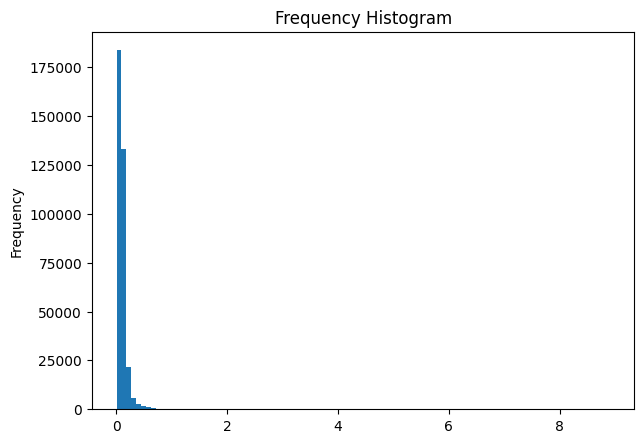

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = losses_normal
plt.hist(x, bins=100)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

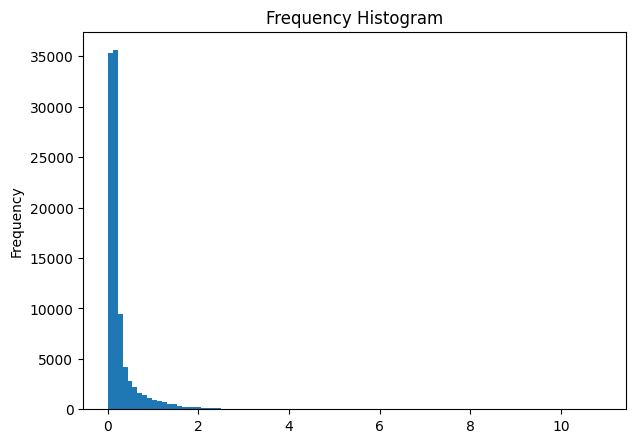

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = losses_anomaly
plt.hist(x, bins=100)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

Text(0, 0.5, 'Frequency')

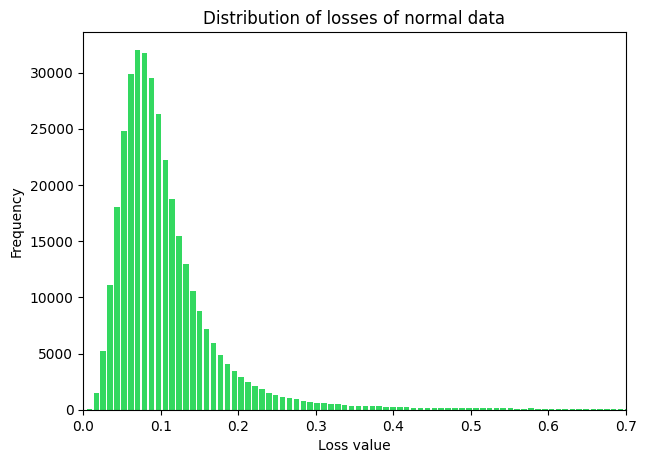

In [147]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = losses_normal

# Get histogram
hist, bins = np.histogram(x, bins=1000)

# Threshold frequency
freq = 0 #500

# Zero out low values
hist[np.where(hist <= freq)] = 0

# Plot
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.xlim([0,0.7])
#plt.margins(0.05)
plt.bar(center, hist, align='center', width=width, color = '#33D860')
plt.title("Distribution of losses of normal data")
plt.xlabel("Loss value")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

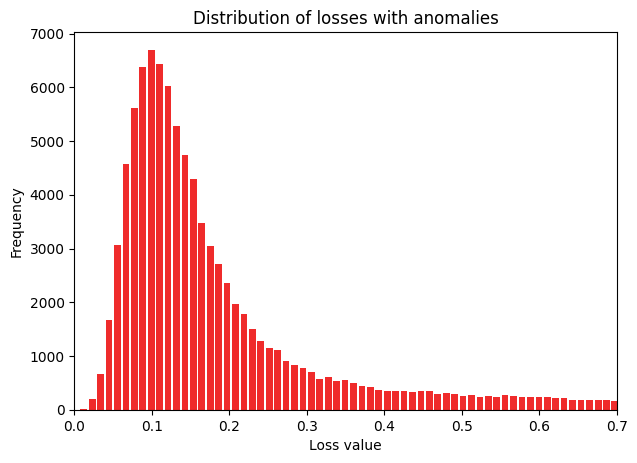

In [146]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = losses_anomaly

# Get histogram
hist, bins = np.histogram(x, bins=1000)

# Threshold frequency
freq = 0 #500

# Zero out low values
hist[np.where(hist <= freq)] = 0

# Plot
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.xlim([0,0.7])
plt.bar(center, hist, align='center', width=width, color='#EF2B2B')
plt.title("Distribution of losses with anomalies")
plt.xlabel("Loss value")
plt.ylabel("Frequency")

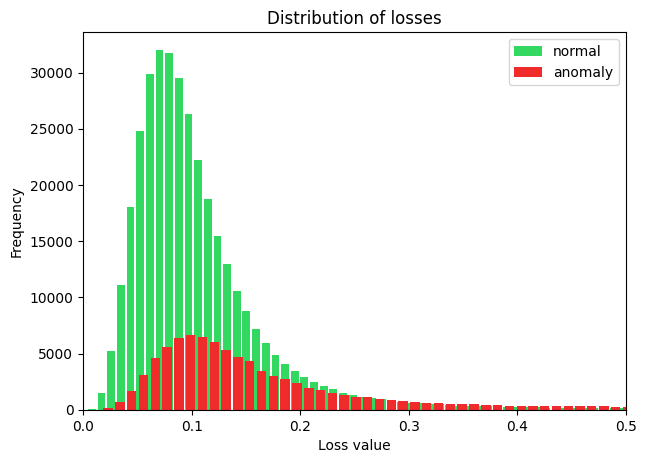

In [145]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = losses_normal

# Get histogram
hist, bins = np.histogram(x, bins=1000)

# Threshold frequency
freq = 0 #500

# Zero out low values
hist[np.where(hist <= freq)] = 0

# Plot
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.xlim([0,0.5])
#plt.margins(0.05)
plt.bar(center, hist, align='center', width=width, color = '#33D860', label='normal')#'#7eb54e')
plt.title("Distribution of losses")
plt.xlabel("Loss value")
plt.ylabel("Frequency")

##############################
# Plot Histogram on x
x = losses_anomaly

# Get histogram
hist, bins = np.histogram(x, bins=1000)

# Threshold frequency
freq = 0 #500

# Zero out low values
hist[np.where(hist <= freq)] = 0

# Plot
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.xlim([0, 0.5])
plt.bar(center, hist, align='center', width=width, color='#EF2B2B',label ='anomaly')#'#7eb54e') #FAAB9A'

plt.legend()

## Latent vectors classification

In [83]:
losses_anomaly = losses_anomaly.reshape(-1, 1)
losses_normal = losses_normal.reshape(-1, 1)

In [87]:
print(features_anomaly.shape)
print(losses_anomaly.shape)

(99870, 4)
(99870, 1)


In [84]:
anomaly_df = np.concatenate((features_anomaly, losses_anomaly, np.ones(losses_anomaly.shape)), axis=1)
normal_df = np.concatenate((features_normal, losses_normal, np.zeros(losses_normal.shape)), axis=1)

In [89]:
df_learn = np.concatenate((normal_df, anomaly_df), axis=0)
df_learn = pd.DataFrame(df_learn)
df_learn[5] = df_learn[5].astype(np.int32)
df_learn.rename(columns={5: 'target'}, inplace=True)

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from xgboost import XGBClassifier

from src import TransactionDatasetNewData, Conv1dAutoEncoder

In [93]:
X_train, X_test, y_train, y_test = train_test_split(
    df_learn[[0, 1, 2, 3, 4]],
    df_learn['target'],
    test_size=.8,
    shuffle=True)

In [94]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

print(f'f1 for train - {f1_score(y_train, log_reg.predict(X_train))}')
print(f'f1 for test - {f1_score(y_test, log_reg.predict(X_test))}')

print(f'roc_auc for train - {roc_auc_score(y_train, log_reg.predict(X_train))}')
print(f'roc_auc for test - {roc_auc_score(y_test, log_reg.predict(X_test))}')

f1 for train - 0.29016862869869553
f1 for test - 0.2934047633379481
roc_auc for train - 0.5809318456507523
roc_auc for test - 0.5822179213425326


In [95]:
xgcl = XGBClassifier(n_estimators=600)
xgcl.fit(X_train, y_train)

print(f'f1 for train - {f1_score(y_train, xgcl.predict(X_train))}')
print(f'f1 for test - {f1_score(y_test, xgcl.predict(X_test))}')

print(f'roc_auc for train - {roc_auc_score(y_train, xgcl.predict(X_train))}')
print(f'roc_auc for test - {roc_auc_score(y_test, xgcl.predict(X_test))}')

f1 for train - 0.6294027063333443
f1 for test - 0.36456055012160765
roc_auc for train - 0.7328307603722787
roc_auc for test - 0.6062169291458417


## PCA

In [149]:
from __future__ import print_function
import time

import numpy as np
import pandas as pd

#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [150]:
df_learn = np.concatenate((normal_df, anomaly_df), axis=0)
df_learn = pd.DataFrame(df_learn)
df_learn[5] = df_learn[5].astype(np.int32)
df_learn.rename(columns={5: 'target'}, inplace=True)

In [151]:
df_pca = df_learn

In [152]:
df_pca.head(20)

0         1         2         3         4  target
0   0.559570  0.260742 -0.258057  0.486572  0.068970       0
1   0.589844  0.296875 -0.127441  0.505859  0.085266       0
2   0.758789  0.088440 -0.036377  0.424805  0.144287       0
3   0.544922  0.198486 -0.292969  0.429688  0.136353       0
4   0.705566  0.077759 -0.260986  0.383545  0.126343       0
5   0.735352 -0.104065 -0.318359  0.270752  0.054596       0
6   0.841797 -0.190918 -0.243042  0.244751  0.099792       0
7   0.802734 -0.221924 -0.270996  0.206665  0.062286       0
8   0.634766  0.089905 -0.214722  0.354004  0.063538       0
9   0.786621 -0.101685 -0.266602  0.273926  0.050598       0
10  0.670898  0.036194 -0.215454  0.325928  0.072083       0
11  0.750000 -0.016403 -0.293457  0.322998  0.056183       0
12  0.655273  0.089050 -0.325195  0.373291  0.064453       0
13  0.604004  0.061707 -0.330811  0.332031  0.056732       0
14  0.687012 -0.032776 -0.325684  0.278809  0.084961       0
15  0.701172 -0.100952 -0.401367  0.254883  0.050568       0
16  0.654297  0.082458 -0.313721  0.382812  0.061401       0
17  0.749512  0.104248 -0.255371  0.445068  0.272705       0
18  0.795410  0.010529 -0.154785  0.372559  0.092102       0
19  0.696289  0.104980 -0.250000  0.441406  0.095154       0

In [166]:
pca = PCA(n_components=2)
feat_cols = ['0','1','2','3'] #,'4'] #with or without loss
feat_cols = [0,1,2,3,4]
pca_result = pca.fit_transform(df_pca[feat_cols].values)

df_pca['pca-one'] = pca_result[:,0]
df_pca['pca-two'] = pca_result[:,1] 
#df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.54120623 0.29803965]


<AxesSubplot: xlabel='pca-one', ylabel='pca-two'>

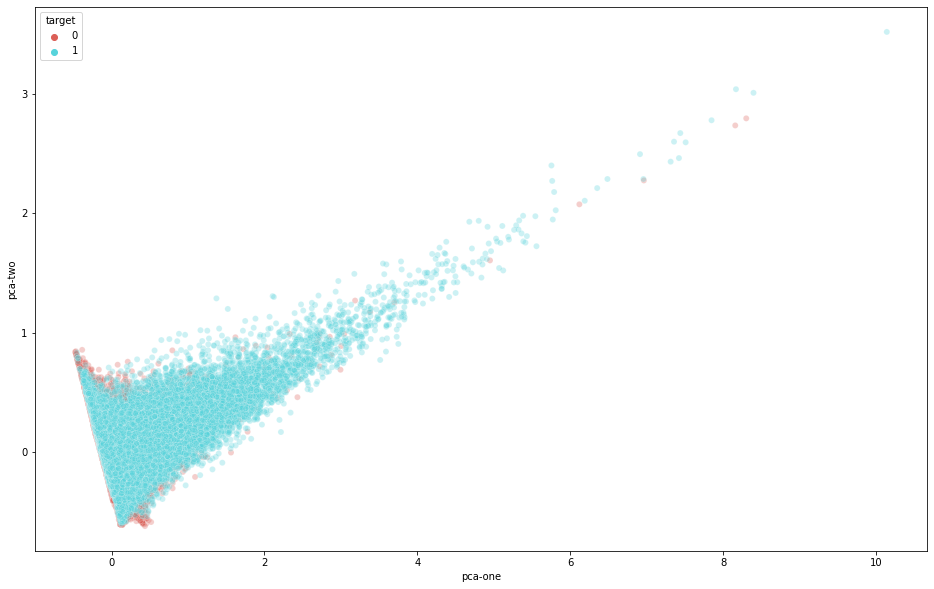

In [167]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

## Correlation between components

<AxesSubplot: xlabel='1', ylabel='2'>

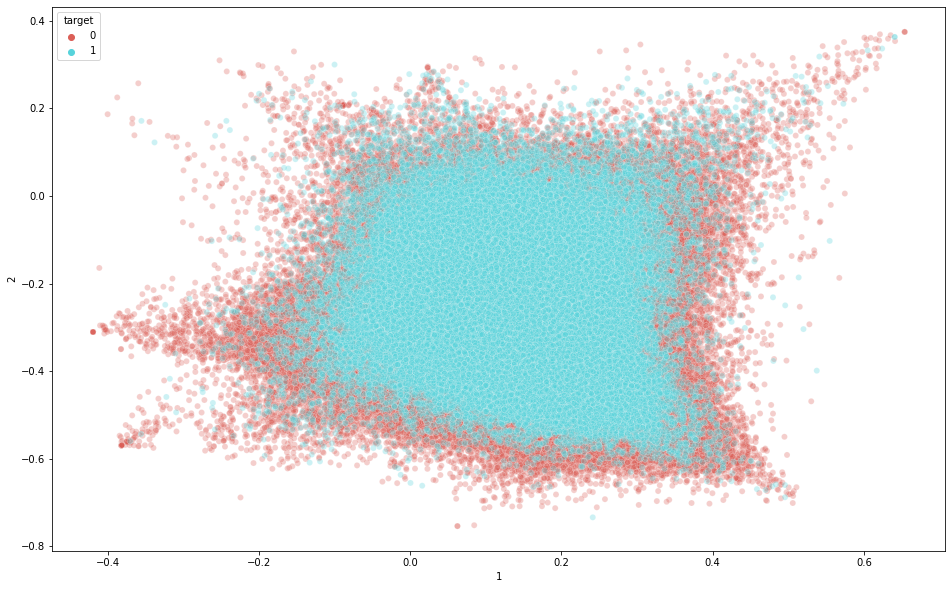

In [169]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=1, y=2, #print here names of columns
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca, #print here name of your dataframe
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='1', ylabel='3'>

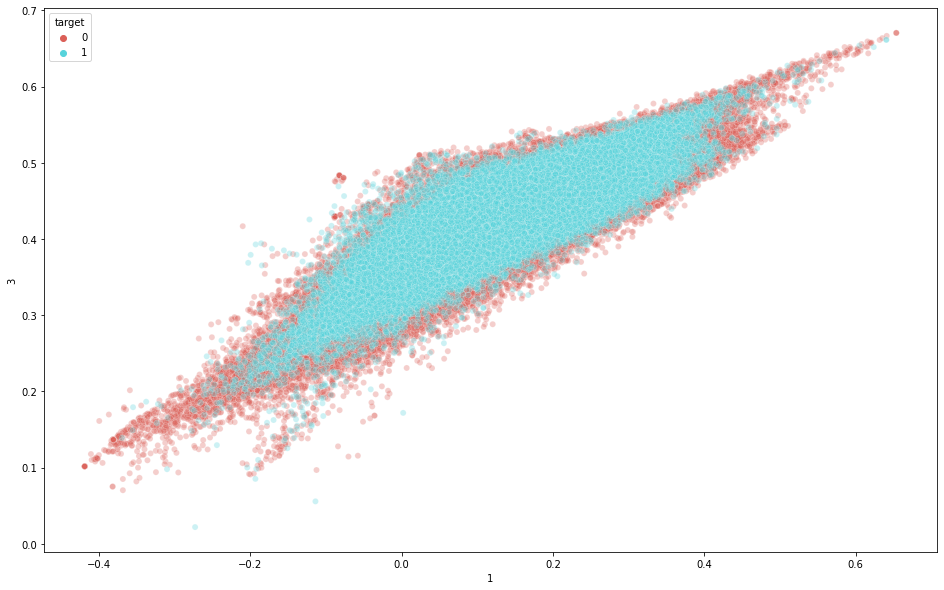

In [170]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=1, y=3,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='1', ylabel='0'>

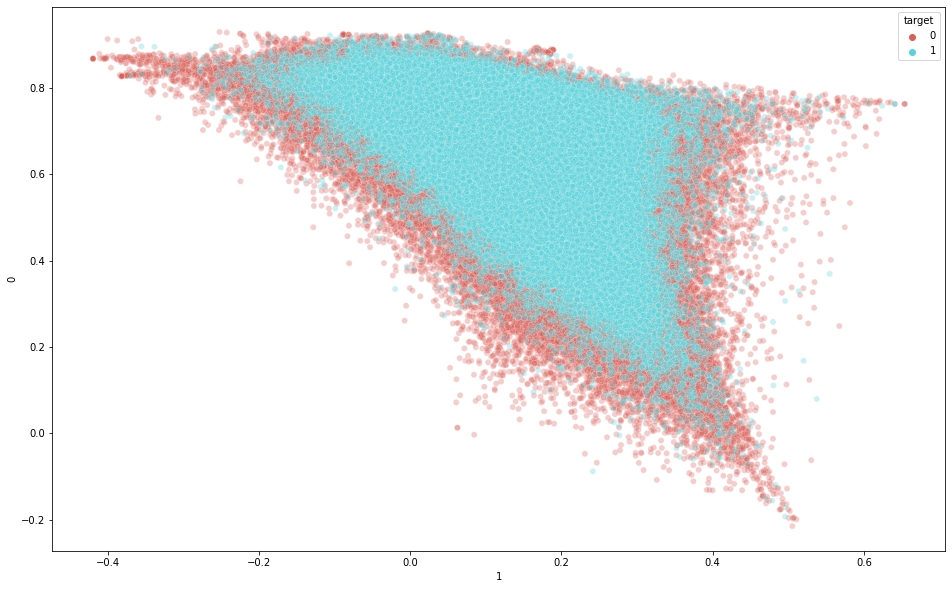

In [171]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=1, y=0,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='1', ylabel='4'>

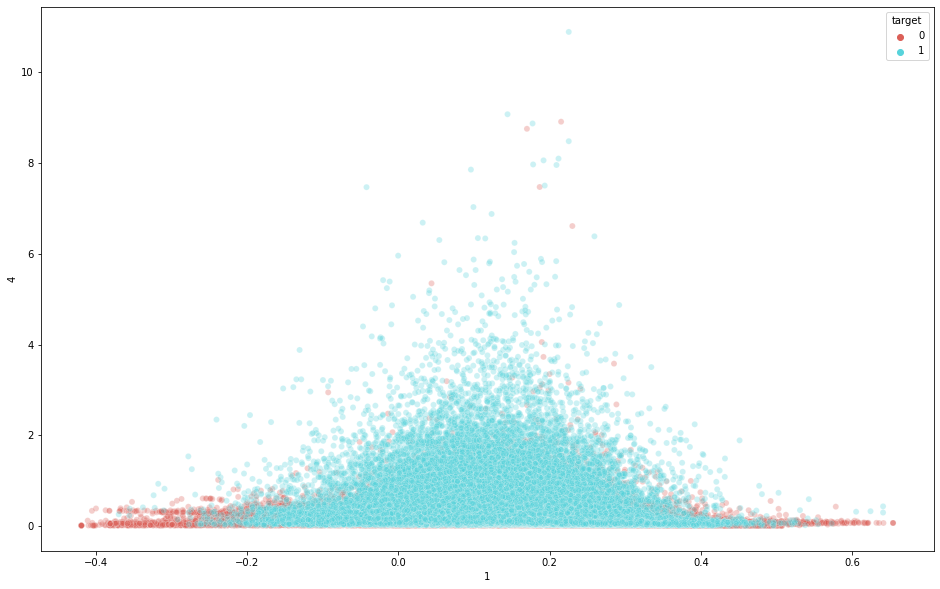

In [172]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=1, y=4,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='0', ylabel='4'>

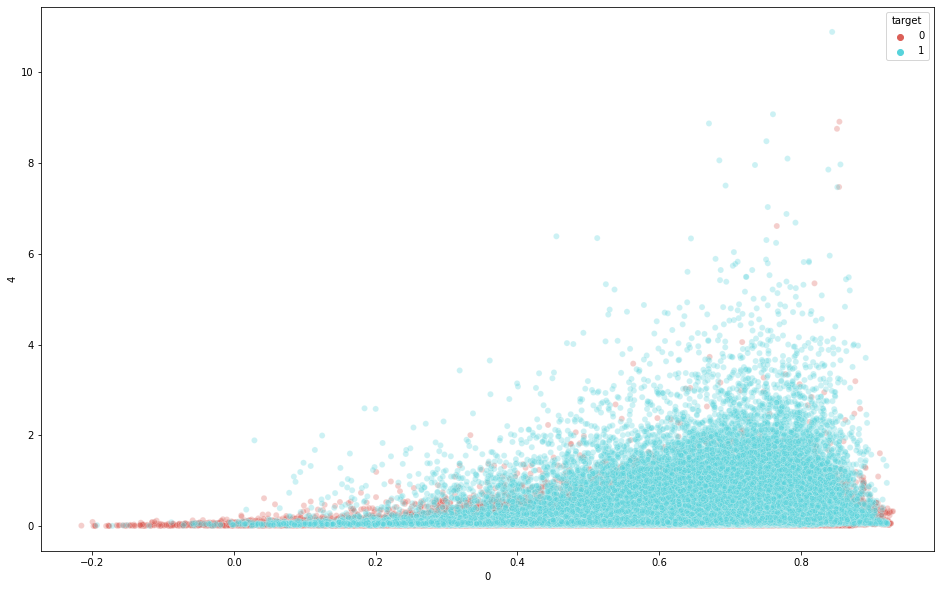

In [173]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, y=4,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='0', ylabel='2'>

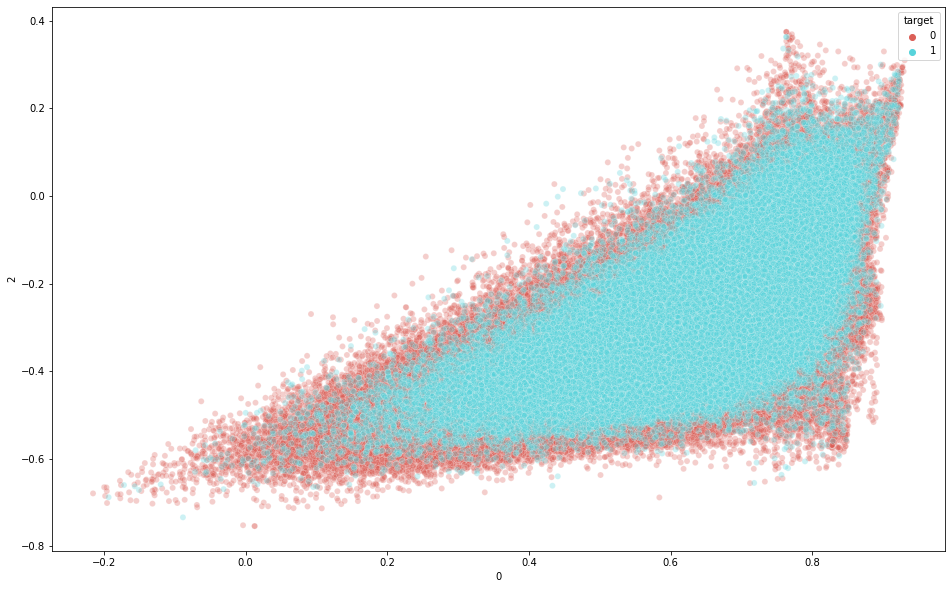

In [174]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, y=2,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='0', ylabel='3'>

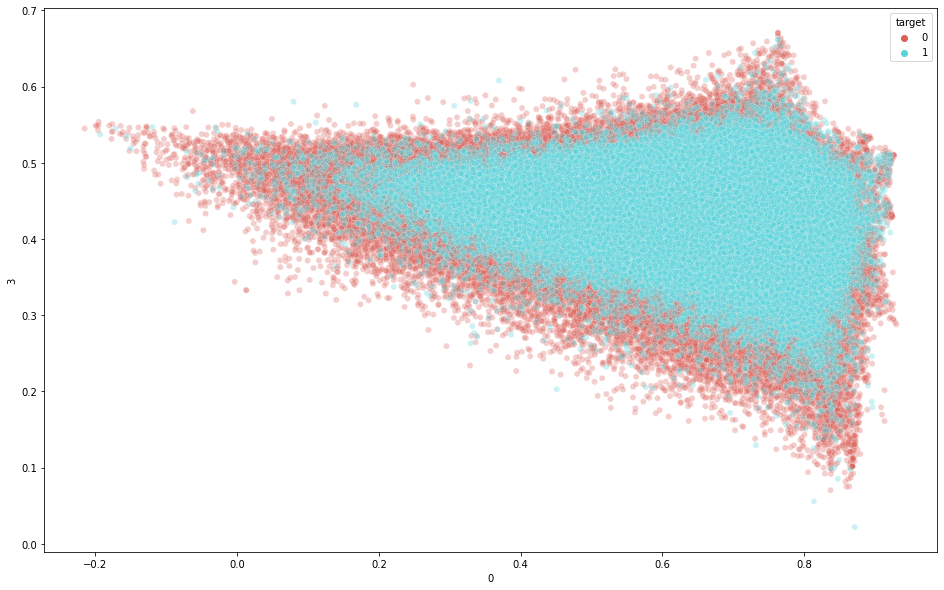

In [175]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, y=3,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='2', ylabel='3'>

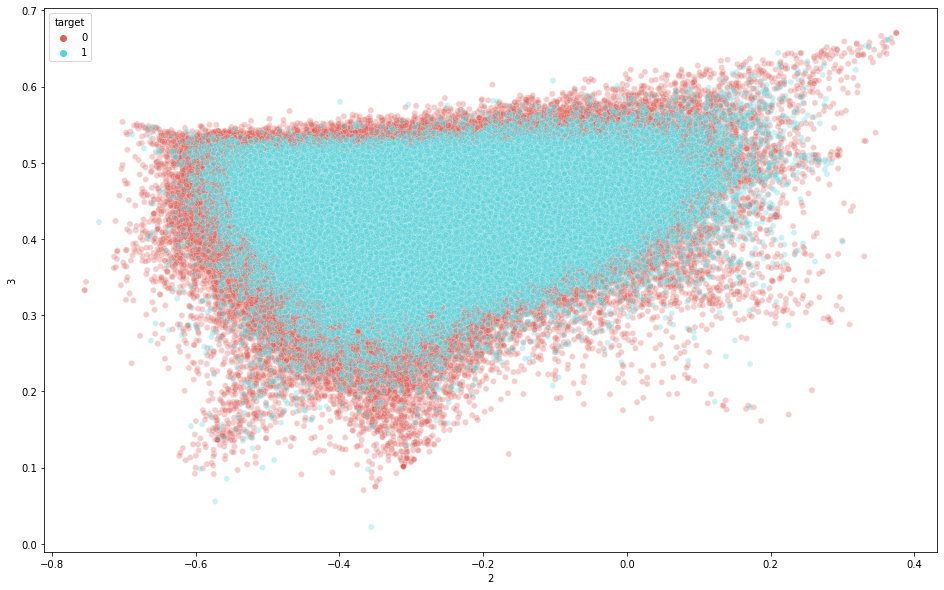

In [176]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=2, y=3,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='2', ylabel='4'>

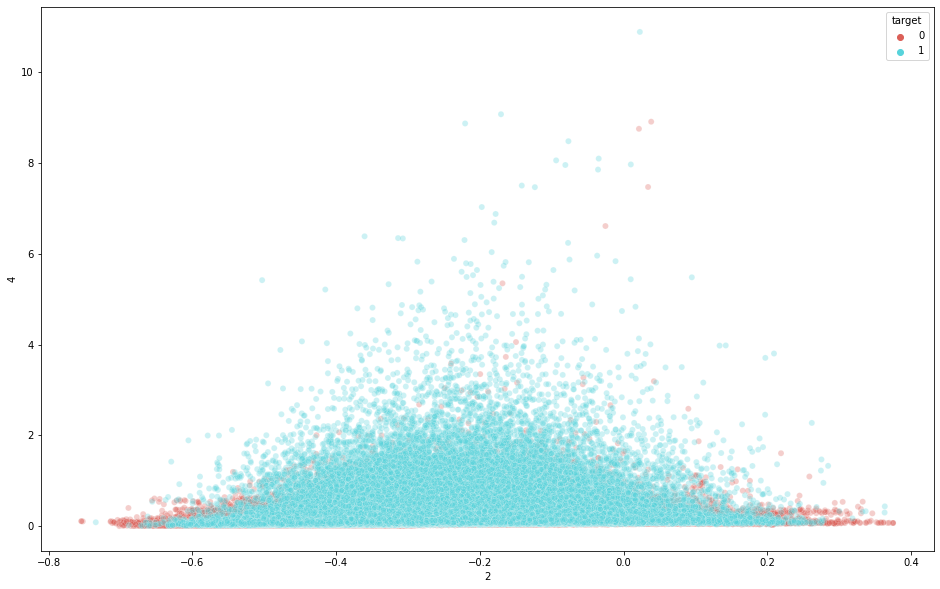

In [177]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=2, y=4,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='3', ylabel='4'>

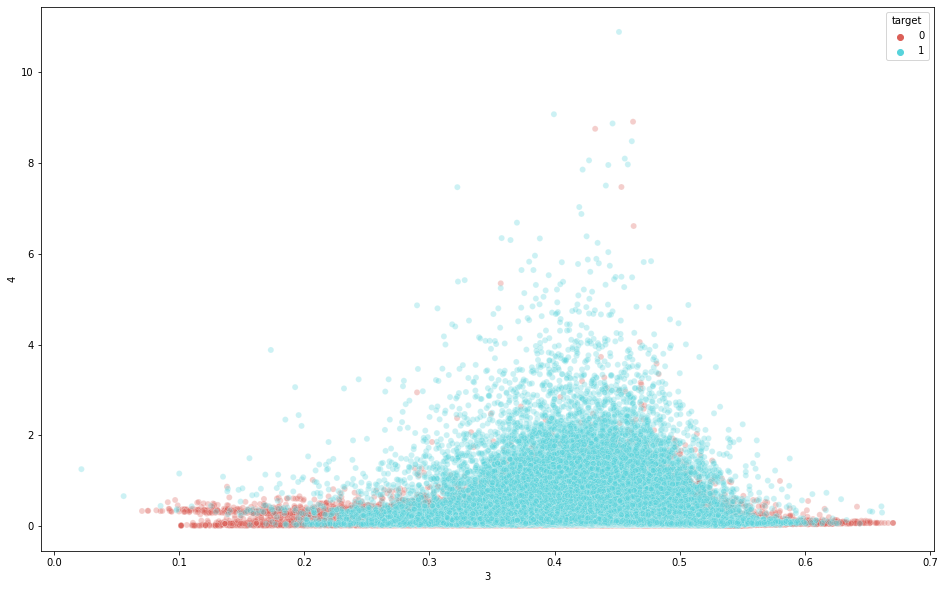

In [178]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=3, y=4,
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.3
)

## Training classifiers on PCA features

In [185]:
X_train, X_test, y_train, y_test = train_test_split(
    df_pca[[0, 1, 2, 3, 4 , 'pca-one','pca-two']],
    df_pca['target'],
    test_size=.8,
    shuffle=True)

In [186]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

print(f'f1 for train - {f1_score(y_train, log_reg.predict(X_train))}')
print(f'f1 for test - {f1_score(y_test, log_reg.predict(X_test))}')

print(f'roc_auc for train - {roc_auc_score(y_train, log_reg.predict(X_train))}')
print(f'roc_auc for test - {roc_auc_score(y_test, log_reg.predict(X_test))}')

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


f1 for train - 0.30230891719745223
f1 for test - 0.2922148738831581
roc_auc for train - 0.585565384914852


C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


roc_auc for test - 0.5816553116779006


In [187]:
xgcl = XGBClassifier(n_estimators=600)
xgcl.fit(X_train, y_train)

print(f'f1 for train - {f1_score(y_train, xgcl.predict(X_train))}')
print(f'f1 for test - {f1_score(y_test, xgcl.predict(X_test))}')

print(f'roc_auc for train - {roc_auc_score(y_train, xgcl.predict(X_train))}')
print(f'roc_auc for test - {roc_auc_score(y_test, xgcl.predict(X_test))}')

f1 for train - 0.6562632075164992
f1 for test - 0.3588693664675203
roc_auc for train - 0.7474198406580453
roc_auc for test - 0.6039401304016683
